# Практика 4: Атака DeepFool на модели ИИ
Выполнил студент группы ББМО-01-23 Стрыбак Вячелсав

Шаг 1: Загрузка обученной модели и данных MNIST

In [21]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9723 - loss: 0.0942
Test accuracy on clean images: 0.9753000140190125


Шаг 2: Теория атаки DeepFool

Атака DeepFool — это метод, который был разработан для минимального изменения изображений с целью заставить классификационную модель ошибиться. В отличие от других атак, таких как FGSM, DeepFool находит минимальные изменения в пространстве признаков, которые достаточны для изменения предсказания модели. Это делает DeepFool более эффективной в создании противоречивых примеров с минимальным изменением входных данных.

Шаг 3: Реализация атаки DeepFool с использованием Foolbox

Установка Foolbox:

In [22]:
pip install foolbox

Реализация атаки DeepFool:

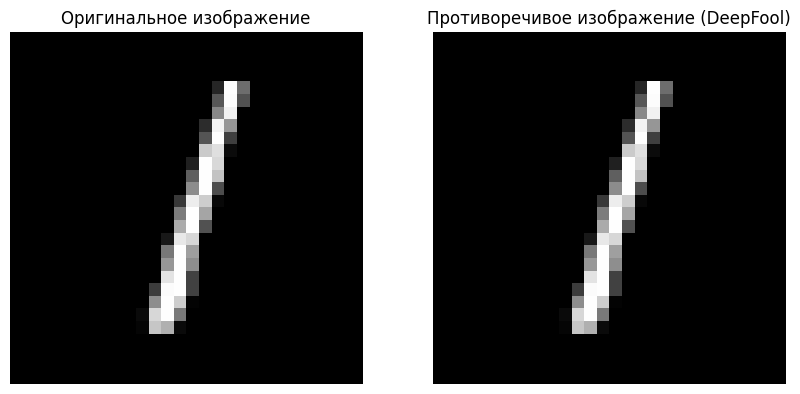

In [23]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[2], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=400)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

Шаг 4: Оценка модели на противоречивых примерах

In [24]:
# Установите количество обрабатываемых изображений

adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси

# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 131.6679
Accuracy on adversarial examples (DeepFool): 0.0


Вывод: Точность модели на противоречивых примерах, созданных с помощью атаки
DeepFool, значительно снизилась до 0 по сравнению с чистыми данными. Это демонстрирует уязвимость модели перед атаками, даже если изменения в изображении минимальны.